# Run Scupa for the IFNB-stimulation data

This R notebook shows an example of running Scupa for immune cell polarization analysis of scRNA-seq data.

In [1]:
library(Seurat)
library(scupa)
library(dplyr)
library(pROC)
library(ggplot2)
library(colorRamps)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




# Convert AnnData to Seurat

Scupa relies on the Seurat data structure, so we need to read the data and cell embeddings into R.

The simplest way is using the package schard:

* https://github.com/cellgeni/schard/

We convert the UCE output h5ad file into a Seurat object.

In [2]:
ifnb <- schard::h5ad2seurat('data/ifnb_count_uce_adata.h5ad')

The UCE embeddings are saved in **Embeddings(ifnb, 'Xuce_')**.

We create an assay **uce** from the cell embeddings. The following clustering and visualization are based on UCE embeddings.

An alternative way is to perform clustering and visualization using RNA features using the standard pipeline, which is not demonstrated in this notebook.

In [3]:
ifnb[['uce']] <- CreateAssayObject(data=t(Embeddings(ifnb, 'Xuce_')))
DefaultAssay(ifnb) <- 'uce'
VariableFeatures(ifnb) <- rownames(ifnb)
ifnb

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


An object of class Seurat 
12024 features across 13999 samples within 2 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 1 other assay present: RNA
 1 dimensional reduction calculated: Xuce_

# Run Scupa

This IFNB-stimulation dataset has several cell types. In this notebook, we show the results of two cell types: CD8 T cells and pDC. 

The polarization of other cell types can be analyzed in a similar manner.

In [4]:
table(ifnb$seurat_annotations)


           B  B Activated    CD14 Mono    CD16 Mono CD4 Memory T  CD4 Naive T 
         978          388         4362         1044         1762         2504 
       CD8 T           DC        Eryth           Mk           NK          pDC 
         814          472           55          236          619          132 
 T activated 
         633 

## CD8 T cells

In [5]:
cd8t <- subset(ifnb, seurat_annotations == 'CD8 T')
cd8t

An object of class Seurat 
12024 features across 814 samples within 2 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 1 other assay present: RNA
 1 dimensional reduction calculated: Xuce_

In [6]:
cd8t <- cd8t %>% 
    ScaleData() %>% 
    RunPCA(npcs = 50, verbose = FALSE) %>% 
    FindNeighbors(dims = 1:20, verbose=FALSE) %>% 
    FindClusters(resolution = 1, verbose=FALSE)%>% 
    RunUMAP(dims = 1:20, verbose=FALSE) 

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


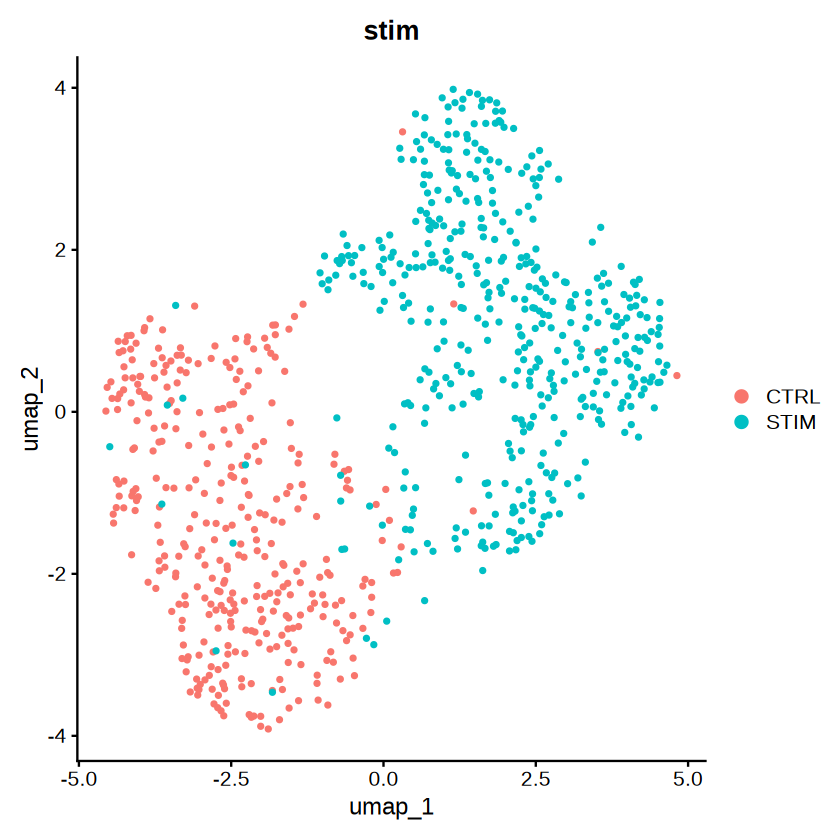

In [7]:
DimPlot(cd8t, group.by='stim')

* CTRL: cells from the unstimulated control sample
* STIM: cells from the IFNB-stimulated sample

**MeasurePolar** is the main function in Scupa. 

The **celltype** parameter must be specified to match the input cells.

The **unpolarized_cell** parameter is optional, but highly recommended. It helps correcting cell embedding batch effect between the input dataset and the reference dataset to improve polarization measurement.

See the documentation of this function (?MeasurePolar) for details.

In [8]:
cd8t <- MeasurePolar(cd8t, celltype='CD8T', unpolarized_cell=WhichCells(cd8t, expression = stim %in% c('CTRL')))

Loaded models and parameters for CD8T

Measure polarization state: T8-a

Measure polarization state: T8-b

Measure polarization state: T8-c

Measure polarization state: T8-e

Measure polarization state: T8-f



We use the ROC curve to evaluate how polarization scores can separate cells from two conditions.

Note that IFNB will drive **-a** state polarization in all cell types.

In [9]:
roc_cd8t <- roc(stim ~ T8.a_score, data=cd8t@meta.data)
roc_cd8t$auc

Setting levels: control = CTRL, case = STIM

Setting direction: controls < cases



Area under the curve: 0.9932

Visualize the polarization scores using FeaturePlot or VlnPlot.

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


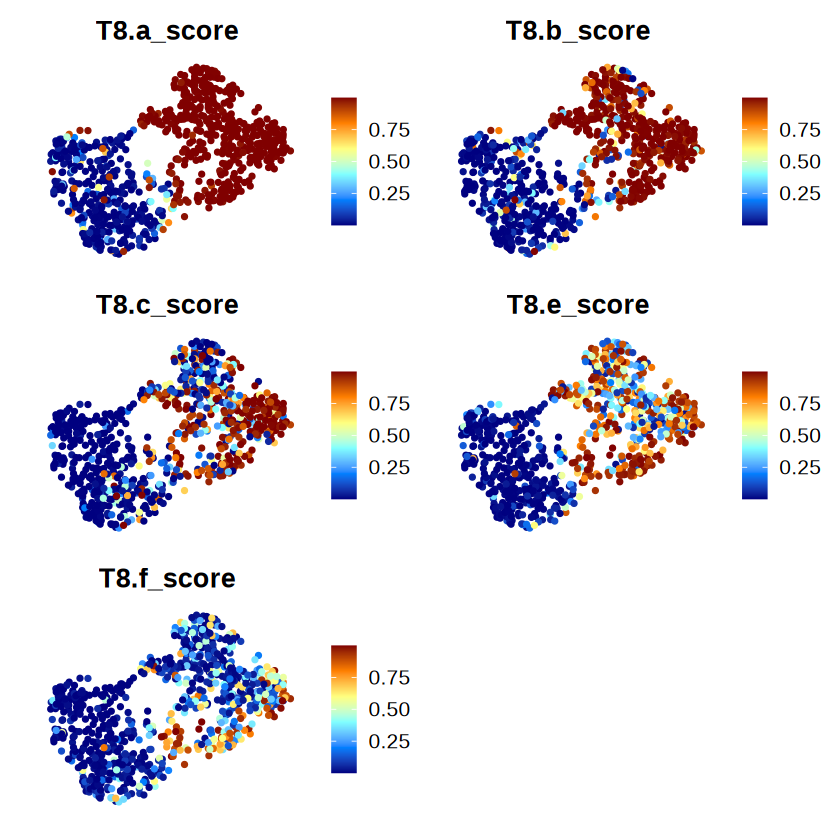

In [10]:
FeaturePlot(cd8t, c('T8.a_score','T8.b_score','T8.c_score','T8.e_score','T8.f_score')) & 
    NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))

By default, Scupa output the conformal prediction of polarization states with error level=0.05.

Conformal prediction may result in predictions of single class, both classes, or neither classes for a binary classification task.

There will be four classes of predictions:

* Polarized: a cell is predicted as polarized.
* Unpolarized: a cell is predicted as unpolarized.
* Intermediate: a cell is predicted as either unpolarized or polarized, meaning that the classifier thinks the cell is similar to both polarized cells and unpolarized cells in the training data.
* Uncertain: a cell is predicted as neither unpolarized nor polarized, meaning that the classifier thinks the cell is dissimilar to both polarized cells and unpolarized cells in the training data.

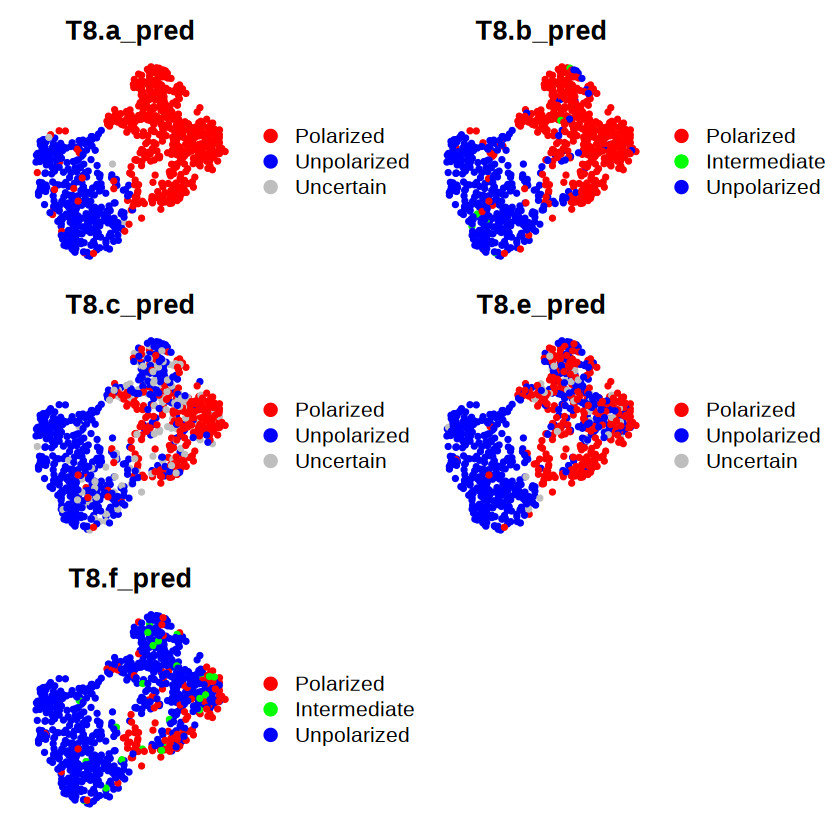

In [11]:
DimPlot(cd8t, group.by=c('T8.a_pred','T8.b_pred','T8.c_pred','T8.e_pred','T8.f_pred'), ncol=2) & 
    NoAxes() & scale_colour_manual(values = c('Polarized'='red','Intermediate'='green','Unpolarized'='blue','Uncertain'='gray'))

### Adjust error level in conformal prediction

You may want to adjust the error level if your data if seeing too many intermediate or uncertain predictions.

In general, decreasing the error level will result in more intermediate predictions (showing below), while increaseing the error level will result in more polarized, unpolarized and uncertain predictions.

The polarization scores will not be affected by the error level.

In [12]:
cd8t <- MeasurePolar(cd8t, celltype='CD8T', unpolarized_cell=WhichCells(cd8t, expression = stim %in% c('CTRL')), error_level=0.01)

Loaded models and parameters for CD8T

Measure polarization state: T8-a

Measure polarization state: T8-b

Measure polarization state: T8-c

Measure polarization state: T8-e

Measure polarization state: T8-f



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


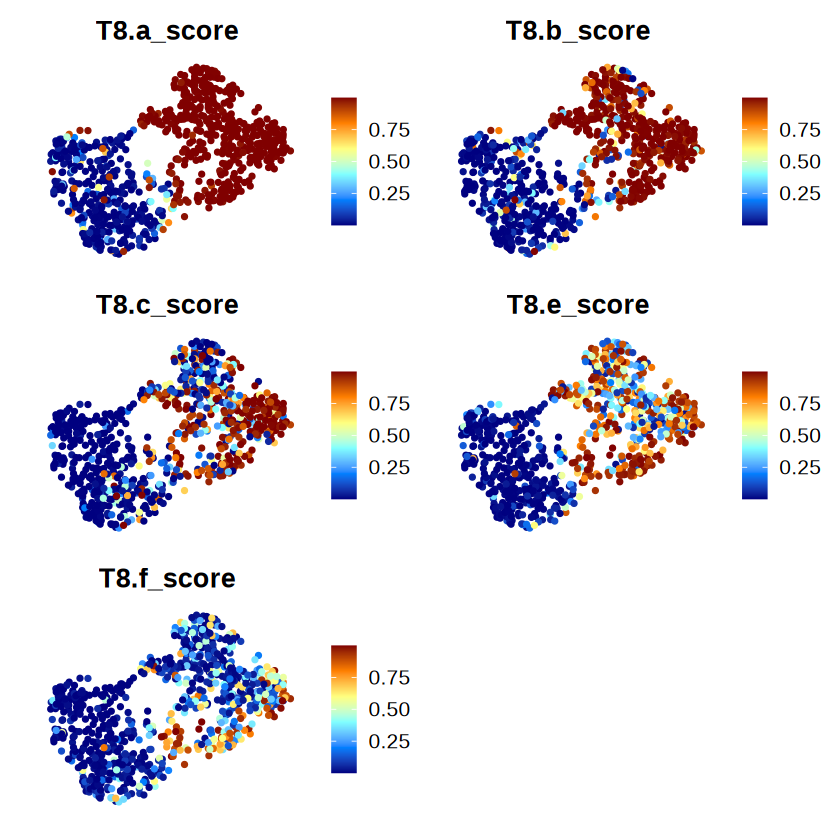

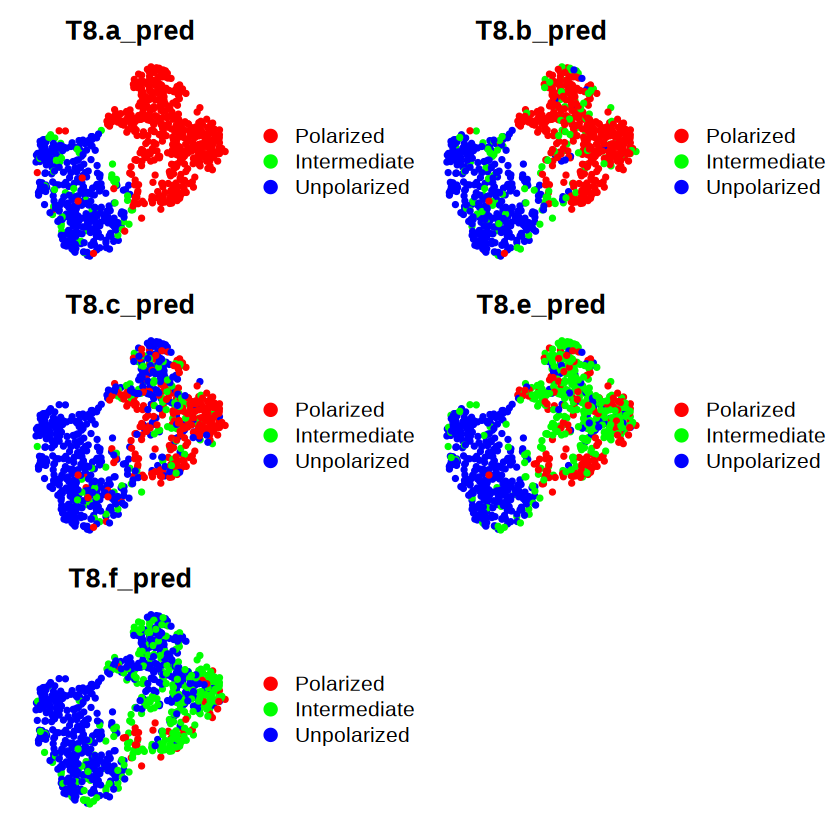

In [13]:
FeaturePlot(cd8t, c('T8.a_score','T8.b_score','T8.c_score','T8.e_score','T8.f_score')) & 
    NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))
DimPlot(cd8t, group.by=c('T8.a_pred','T8.b_pred','T8.c_pred','T8.e_pred','T8.f_pred'), ncol=2) & 
    NoAxes() & scale_colour_manual(values = c('Polarized'='red','Intermediate'='green','Unpolarized'='blue','Uncertain'='gray'))

## pDC

In [14]:
pdc <- subset(ifnb, seurat_annotations == 'pDC')
pdc

An object of class Seurat 
12024 features across 132 samples within 2 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 1 other assay present: RNA
 1 dimensional reduction calculated: Xuce_

In [15]:
pdc <- pdc %>% 
    ScaleData() %>% 
    RunPCA(verbose = FALSE, npcs = 50) %>% 
    FindNeighbors(dims = 1:20, verbose=FALSE, k.param=20) %>% 
    FindClusters(resolution = 1, verbose=FALSE)%>% 
    RunUMAP(dims = 1:20, verbose=FALSE) 

Centering and scaling data matrix



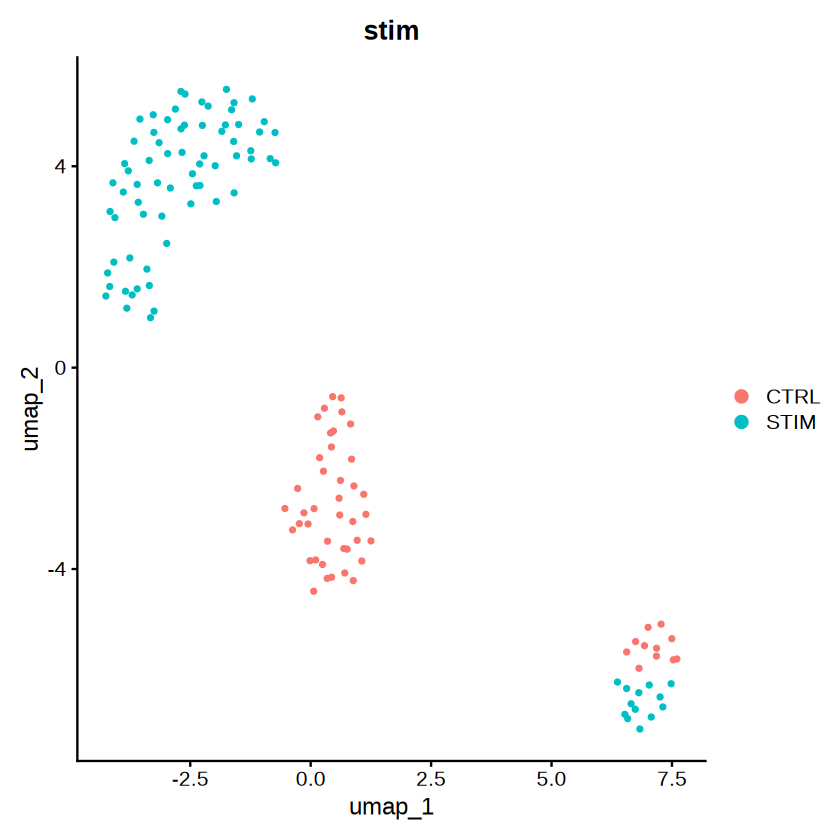

In [16]:
DimPlot(pdc, group.by='stim')

In [17]:
pdc <- MeasurePolar(pdc, celltype='pDC', unpolarized_cell=WhichCells(pdc, expression = stim=='CTRL'))

Loaded models and parameters for pDC

Measure polarization state: pDC-a

Measure polarization state: pDC-b

Measure polarization state: pDC-c

Measure polarization state: pDC-d

Measure polarization state: pDC-e



In [18]:
roc_pdc <- roc(stim ~ pDC.a_score, data=pdc@meta.data)
roc_pdc$auc

Setting levels: control = CTRL, case = STIM

Setting direction: controls < cases



Area under the curve: 0.9973

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


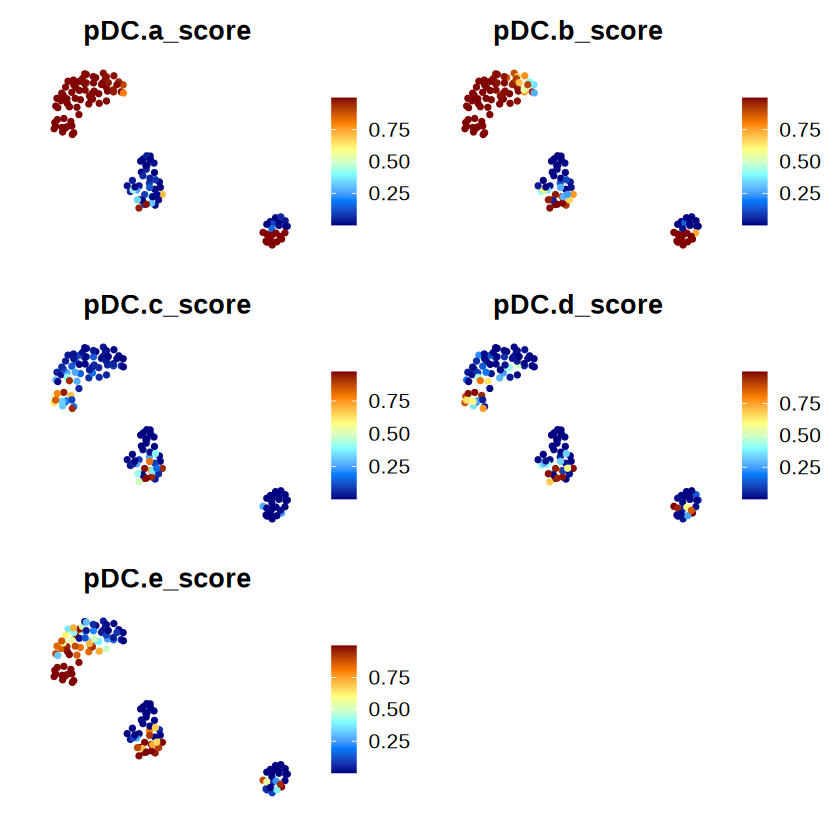

In [19]:
FeaturePlot(pdc, c('pDC.a_score','pDC.b_score','pDC.c_score','pDC.d_score','pDC.e_score')) & 
    NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))

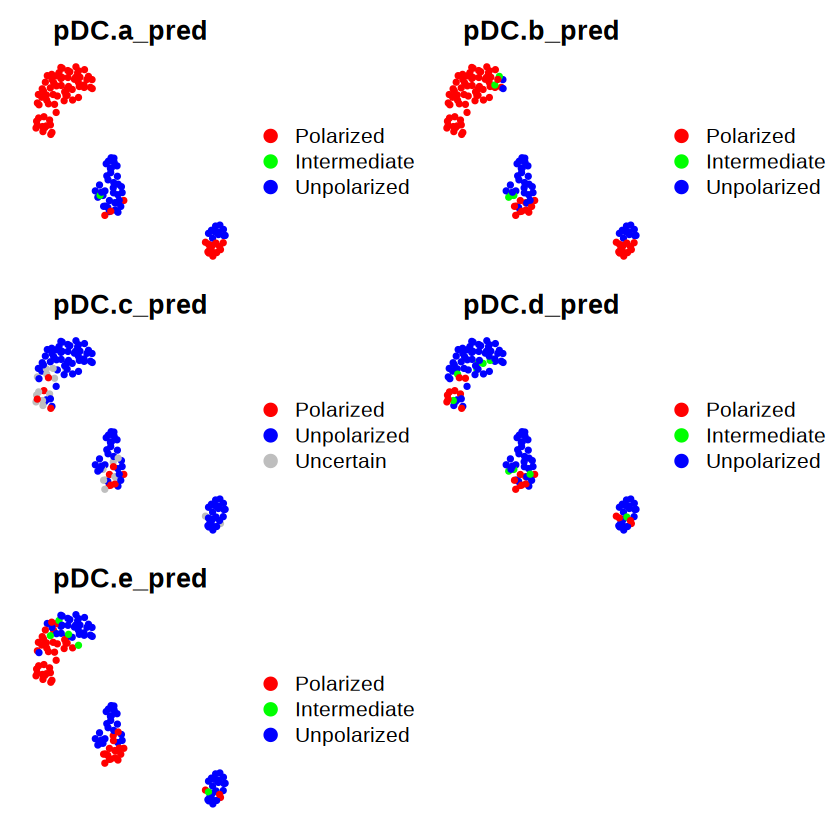

In [20]:
DimPlot(pdc, group.by=c('pDC.a_pred','pDC.b_pred','pDC.c_pred','pDC.d_pred','pDC.e_pred'), ncol=2) & 
    NoAxes() & scale_colour_manual(values = c('Polarized'='red','Intermediate'='green','Unpolarized'='blue','Uncertain'='gray'))

In [21]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-conda-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data1/data2/wliu12/miniconda3/envs/rnew/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Chicago
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] colorRamps_2.3.4   ggplot2_3.5.1      pROC_1.18.5        dplyr_1.1.4       
[5] scupa_1.1.0        Seurat_5.1.0       SeuratObject_5.0.2 sp_2.1-4          

loaded via a namespace (and not attached):
  [1] RColorBrewer_